In [1]:
#calculate overlap of lesions with OCD hotspot from Garance with efield method

In [2]:
from nilearn import image
from nilearn.image import load_img
from nilearn.image import math_img
from nilearn.maskers import NiftiMasker
from scipy import stats
from scipy.io import loadmat
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import numpy as np
import nibabel as nib
import pandas as pd
import os,glob
import seaborn as sns
import matplotlib.pyplot as plt

# Load Subjects in Matrix and Hotspots

In [4]:
#load subject matrix
def load_matrix():
    data = loadmat('/Volumes/Cingulate/Sweetspot_Seg/subject_matrix.mat')
    first_matrix = data['first_matrix']
    masker = NiftiMasker(mask_img='/Volumes/Cingulate/Sweetspot_Seg/Outputs/binary/zones1-2/binary_zones1-2_n-map.nii.gz', standardize=True)
    mask_nii = masker.fit()
    return mask_nii, first_matrix

#index matrix and df by cohort
def matrix_df_selection(first_matrix,df_array):
    ranges = [(0, 3), (4, 5), (6, 18), (19, 21), (22, 25), (26, 27), (28, 29), (30, 32), (32, 33), (34, 37), (38, 39), (40, 47)]
    second_matrix,df_selection = first_matrix.copy(),df_array.copy()
    
    #make cohort matricies
    cingulotomy_rows = np.concatenate([np.arange(start, end) for start, end in ranges])
    cingulotomy_matrix = second_matrix[cingulotomy_rows]
    cap_sct_matrix = np.delete(second_matrix,cingulotomy_rows,axis=0)
    
    #make clinical outcomes cohorts
    cingulotomy_df = df_selection[cingulotomy_rows]
    cap_sct_df = np.delete(df_selection,cingulotomy_rows, axis=0)
    
    return cingulotomy_matrix, cap_sct_matrix, cingulotomy_df, cap_sct_df

df = pd.read_csv('/Volumes/Cingulate/Sweetspot_Seg/All_YBOCS_Flip.csv')
df_array = df['Relative'].to_numpy().reshape(-1, 1) #change for absolute vs relative

mask_nii, first_matrix = load_matrix()
cingulotomy_matrix, cap_sct_matrix, cingulotomy_df, cap_sct_df = matrix_df_selection(first_matrix,df_array)

In [38]:
def create_subcohorts(ranges): #create selection from main matrix
    second_cap_sct_matrix,cap_sct_df_selection = cap_sct_matrix.copy(),cap_sct_df.copy()
    rows = np.concatenate([np.arange(start, end) for start, end in ranges])
    matrix = second_cap_sct_matrix[rows]
    df = cap_sct_df_selection[rows]
    return matrix, df
    
def delete_subcohorts(ranges): #create inverse selection
    second_cap_sct_matrix,cap_sct_df_selection = cap_sct_matrix.copy(),cap_sct_df.copy()
    rows = np.concatenate([np.arange(start, end) for start, end in ranges])
    matrix = np.delete(second_cap_sct_matrix,rows,axis=0)
    df = np.delete(cap_sct_df_selection,rows, axis=0)
    return matrix, df
    
#set ranges of each cohort in matrix and csv
brazil_ranges = [(16,21),(22,25),(27,32)]
canada_ranges = [(10,16),(21,22),(25,27),(32,34)]
sct_range = [(0,10)]
    
brazil_matrix, brazil_df = create_subcohorts(brazil_ranges)
canada_matrix, canada_df = create_subcohorts(canada_ranges)
sct_matrix, sct_df = create_subcohorts(sct_range)
brazil_canada_matrix,brazil_canada_df = delete_subcohorts(sct_range)
brazil_sct_matrix,brazil_sct_df = delete_subcohorts(canada_ranges)
canada_sct_matrix,canada_sct_df = delete_subcohorts(brazil_ranges)

In [16]:
#make matrix out of subjects using the binary n-map mask
def make_matrix(mask,path):
    nifti_masker = NiftiMasker(mask_img=mask)
    fmri_masked = nifti_masker.fit_transform(path)
    print('finished')
    return nifti_masker, fmri_masked

path = glob.glob(os.path.join('/Volumes/Cingulate/Sweetspot_Seg/OCD_Hotspots','*.nii.gz'))
mask = '/Volumes/Cingulate/Sweetspot_Seg/Outputs/binary/zones1-2/binary_zones1-2_n-map.nii.gz'

mask_nii,g_hotspot_matrix = make_matrix(mask,path)

finished


# Efield Overlap

In [53]:
def sweetspot_score():
    efield_matrix = brazil_canada_matrix.copy()
    df_column = brazil_canada_df.flatten()
    #make empty matricies to store outputs in
    all_sig_sweetspot_score,pos_sweetspot_score,pos_sig_sweetspot_score = np.zeros(efield_matrix.shape[0]),np.zeros(efield_matrix.shape[0]),np.zeros(efield_matrix.shape[0])
    all_sig_pearson_sweetspot_corr,pos_pearson_sweetspot_corr,pos_sig_pearson_sweetspot_corr = np.zeros((efield_matrix.shape[0])),np.zeros((efield_matrix.shape[0])),np.zeros((efield_matrix.shape[0]))
    all_sig_spearman_sweetspot_corr,pos_spearman_sweetspot_corr,pos_sig_spearman_sweetspot_corr = np.zeros((efield_matrix.shape[0])),np.zeros((efield_matrix.shape[0])),np.zeros((efield_matrix.shape[0]))
    
    for i in range(efield_matrix.shape[0]):
        #multiply voxels together in subject efield and r-map and then average the row together
        all_sig_sweetspot_score[i] = np.mean(np.multiply(g_hotspot_matrix[0][efield_matrix[i, :] != 0], efield_matrix[i, efield_matrix[i, :] != 0]))
        pos_sweetspot_score[i] = np.mean(np.multiply(g_hotspot_matrix[1][efield_matrix[i, :] != 0], efield_matrix[i, efield_matrix[i, :] != 0]))
        pos_sig_sweetspot_score[i] = np.mean(np.multiply(g_hotspot_matrix[2][efield_matrix[i, :] != 0], efield_matrix[i, efield_matrix[i, :] != 0]))
                
        #correlate clinical outcomes with sweetspot_score
        all_sig_pearson_sweetspot_corr[i],p = pearsonr(all_sig_sweetspot_score,df_column)
        pos_pearson_sweetspot_corr[i],p = pearsonr(pos_sweetspot_score,df_column)
        pos_sig_pearson_sweetspot_corr[i],p = pearsonr(pos_sig_sweetspot_score,df_column)
        
        all_sig_spearman_sweetspot_corr[i],p = spearmanr(all_sig_sweetspot_score,df_column)
        pos_spearman_sweetspot_corr[i],p = spearmanr(pos_sweetspot_score,df_column)
        pos_sig_spearman_sweetspot_corr[i],p = spearmanr(pos_sig_sweetspot_score,df_column)


    #overall r and p values
    all_sig_pearson_r,all_sig_pearson_p = pearsonr(all_sig_pearson_sweetspot_corr,df_column)
    pos_pearson_r,pos_pearson_p = pearsonr(pos_pearson_sweetspot_corr,df_column)
    pos_sig_pearson_r,pos_sig_pearson_p = pearsonr(pos_sig_pearson_sweetspot_corr,df_column)
    
    s_all_sig_pearson_r,s_all_sig_pearson_p = spearmanr(all_sig_pearson_sweetspot_corr,df_column)
    s_pos_pearson_r,s_pos_pearson_p = spearmanr(pos_pearson_sweetspot_corr,df_column)
    s_pos_sig_pearson_r,s_pos_sig_pearson_p = spearmanr(pos_sig_pearson_sweetspot_corr,df_column)
    
    all_sig_spearman_r,all_sig_spearman_p = spearmanr(all_sig_spearman_sweetspot_corr,df_column)
    pos_spearman_r,pos_spearman_p = spearmanr(pos_spearman_sweetspot_corr,df_column)
    pos_sig_spearman_r,pos_sig_spearman_p = spearmanr(pos_sig_spearman_sweetspot_corr,df_column)
    
    p_all_sig_spearman_r,p_all_sig_spearman_p = pearsonr(all_sig_spearman_sweetspot_corr,df_column)
    p_pos_spearman_r,p_pos_spearman_p = pearsonr(pos_spearman_sweetspot_corr,df_column)
    p_pos_sig_spearman_r,p_pos_sig_spearman_p = pearsonr(pos_sig_spearman_sweetspot_corr,df_column)

    return all_sig_sweetspot_score,pos_sweetspot_score,pos_sig_sweetspot_score,all_sig_pearson_sweetspot_corr,pos_pearson_sweetspot_corr,pos_sig_pearson_sweetspot_corr,all_sig_spearman_sweetspot_corr,pos_spearman_sweetspot_corr,pos_sig_spearman_sweetspot_corr,all_sig_pearson_r,all_sig_pearson_p,pos_pearson_r,pos_pearson_p,pos_sig_pearson_r,pos_sig_pearson_p,s_all_sig_pearson_r,s_all_sig_pearson_p,s_pos_pearson_r,s_pos_pearson_p,s_pos_sig_pearson_r,s_pos_sig_pearson_p,all_sig_spearman_r,all_sig_spearman_p,pos_spearman_r,pos_spearman_p,pos_sig_spearman_r,pos_sig_spearman_p,p_all_sig_spearman_r,p_all_sig_spearman_p,p_pos_spearman_r,p_pos_spearman_p,p_pos_sig_spearman_r,p_pos_sig_spearman_p

all_sig_sweetspot_score,pos_sweetspot_score,pos_sig_sweetspot_score,all_sig_pearson_sweetspot_corr,pos_pearson_sweetspot_corr,pos_sig_pearson_sweetspot_corr,all_sig_spearman_sweetspot_corr,pos_spearman_sweetspot_corr,pos_sig_spearman_sweetspot_corr,all_sig_pearson_r,all_sig_pearson_p,pos_pearson_r,pos_pearson_p,pos_sig_pearson_r,pos_sig_pearson_p,s_all_sig_pearson_r,s_all_sig_pearson_p,s_pos_pearson_r,s_pos_pearson_p,s_pos_sig_pearson_r,s_pos_sig_pearson_p,all_sig_spearman_r,all_sig_spearman_p,pos_spearman_r,pos_spearman_p,pos_sig_spearman_r,pos_sig_spearman_p,p_all_sig_spearman_r,p_all_sig_spearman_p,p_pos_spearman_r,p_pos_spearman_p,p_pos_sig_spearman_r,p_pos_sig_spearman_p = sweetspot_score()

# Plots

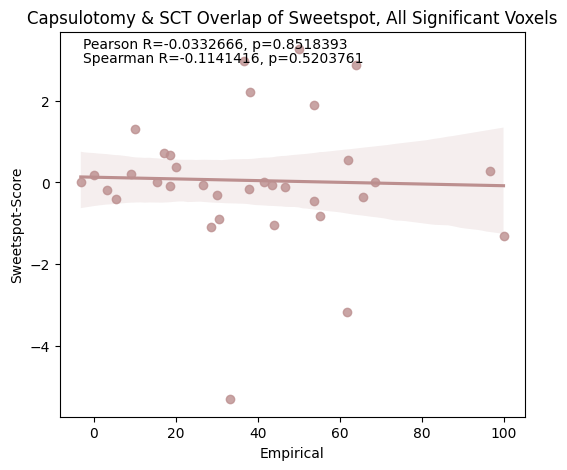

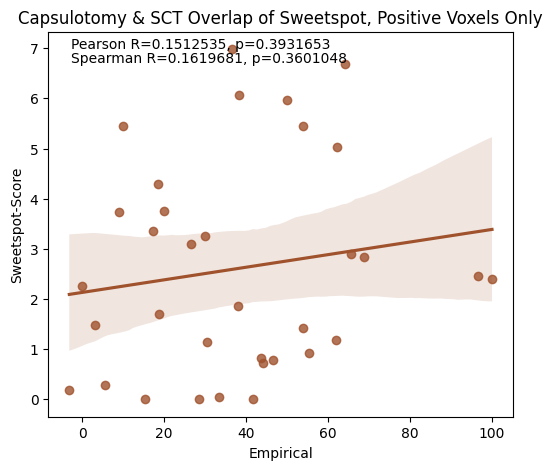

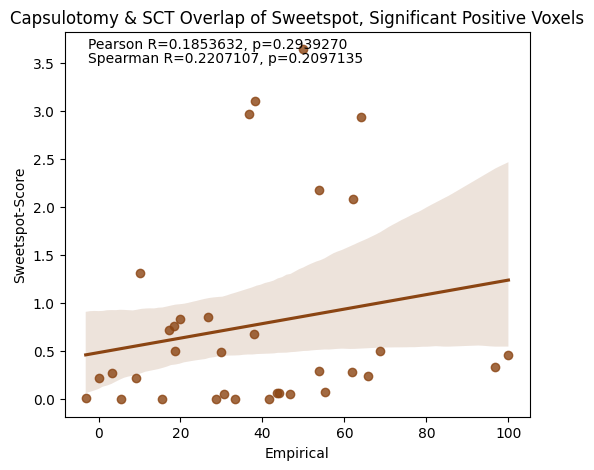

In [51]:
#analysis for capsulotomies and scts, relative, overlap/score
df_column = cap_sct_df.flatten()
p_all_sig_r,p_all_sig_p = pearsonr(all_sig_sweetspot_score,df_column)
p_pos_r,p_pos_p = pearsonr(pos_sweetspot_score,df_column)
p_pos_sig_r,p_pos_sig_p = pearsonr(pos_sig_sweetspot_score,df_column)

s_all_sig_r,s_all_sig_p = spearmanr(all_sig_sweetspot_score,df_column)
s_pos_r,s_pos_p = spearmanr(pos_sweetspot_score,df_column)
s_pos_sig_r,s_pos_sig_p = spearmanr(pos_sig_sweetspot_score,df_column)

def plot_analysis(x_data, y_data, title, pearson_r_val, pearson_p_val, spearman_r_val, spearman_p_val, color,save_path=None):
    plt.figure(figsize=(6, 5))
    ax = sns.regplot(x=x_data, y=y_data, color=color)
    plt.title(title)
    plt.xlabel('Empirical')
    plt.ylabel('Sweetspot-Score')
    ax.text(0.05, 0.95, 'Pearson R={:.7f}, p={:.7f}'.format(pearson_r_val, pearson_p_val),
            transform=ax.transAxes, verticalalignment='bottom')
    ax.text(0.05, 0.95, 'Spearman R={:.7f}, p={:.7f}'.format(spearman_r_val, spearman_p_val),
            transform=ax.transAxes, verticalalignment='top')
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

plot_analysis(cap_sct_df, all_sig_sweetspot_score, 'Capsulotomy & SCT Overlap of Sweetspot, All Significant Voxels', p_all_sig_r, p_all_sig_p, s_all_sig_r, s_all_sig_p, 'rosybrown','/Volumes/Cingulate/Sweetspot_Seg/OCD_Hotspots/Outputs/capsulotomies&sct_all_sig_overlap.png')
plot_analysis(cap_sct_df, pos_sweetspot_score, 'Capsulotomy & SCT Overlap of Sweetspot, Positive Voxels Only',p_pos_r, p_pos_p, s_pos_r, s_pos_p, 'sienna','/Volumes/Cingulate/Sweetspot_Seg/OCD_Hotspots/Outputs/capsulotomies&sct_pos_overlap.png')
plot_analysis(cap_sct_df, pos_sig_sweetspot_score, 'Capsulotomy & SCT Overlap of Sweetspot, Significant Positive Voxels',p_pos_sig_r, p_pos_sig_p, s_pos_sig_r, s_pos_sig_p, 'saddlebrown','/Volumes/Cingulate/Sweetspot_Seg/OCD_Hotspots/Outputs/capsulotomies&sct_pos_sig_overlap.png')

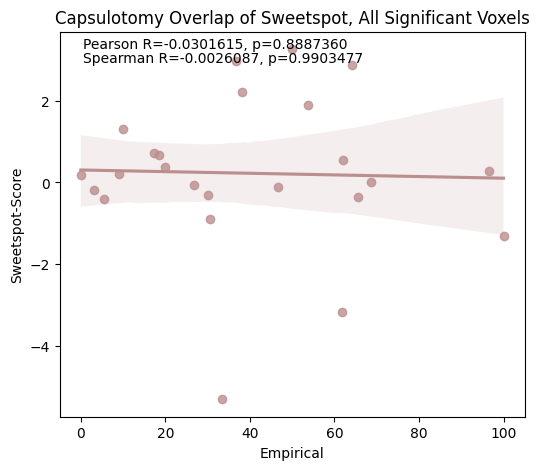

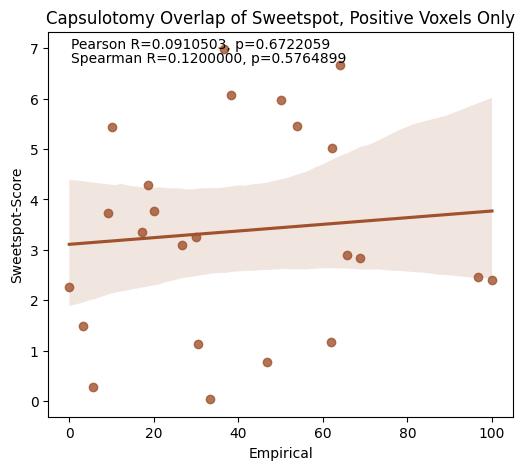

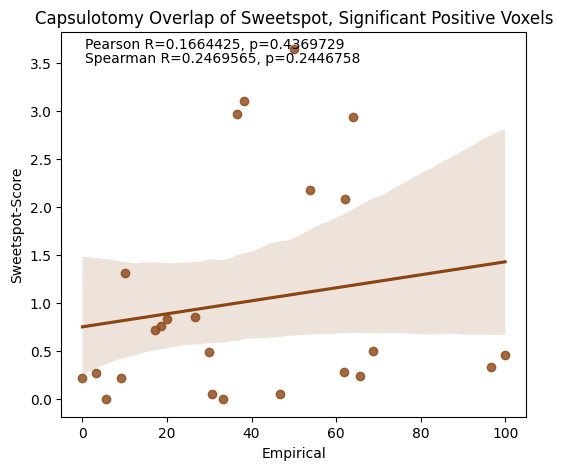

In [46]:
#analysis for capsulotomy, relative, overlap/score
df_column = brazil_canada_df.flatten()
p_all_sig_r,p_all_sig_p = pearsonr(all_sig_sweetspot_score,df_column)
p_pos_r,p_pos_p = pearsonr(pos_sweetspot_score,df_column)
p_pos_sig_r,p_pos_sig_p = pearsonr(pos_sig_sweetspot_score,df_column)

s_all_sig_r,s_all_sig_p = spearmanr(all_sig_sweetspot_score,df_column)
s_pos_r,s_pos_p = spearmanr(pos_sweetspot_score,df_column)
s_pos_sig_r,s_pos_sig_p = spearmanr(pos_sig_sweetspot_score,df_column)

def plot_analysis(x_data, y_data, title, pearson_r_val, pearson_p_val, spearman_r_val, spearman_p_val, color,save_path=None):
    plt.figure(figsize=(6, 5))
    ax = sns.regplot(x=x_data, y=y_data, color=color)
    plt.title(title)
    plt.xlabel('Empirical')
    plt.ylabel('Sweetspot-Score')
    ax.text(0.05, 0.95, 'Pearson R={:.7f}, p={:.7f}'.format(pearson_r_val, pearson_p_val),
            transform=ax.transAxes, verticalalignment='bottom')
    ax.text(0.05, 0.95, 'Spearman R={:.7f}, p={:.7f}'.format(spearman_r_val, spearman_p_val),
            transform=ax.transAxes, verticalalignment='top')
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

plot_analysis(brazil_canada_df, all_sig_sweetspot_score, 'Capsulotomy Overlap of Sweetspot, All Significant Voxels', p_all_sig_r, p_all_sig_p, s_all_sig_r, s_all_sig_p, 'rosybrown','/Volumes/Cingulate/Sweetspot_Seg/OCD_Hotspots/Outputs/capsulotomies_all_sig_overlap.png')
plot_analysis(brazil_canada_df, pos_sweetspot_score, 'Capsulotomy Overlap of Sweetspot, Positive Voxels Only',p_pos_r, p_pos_p, s_pos_r, s_pos_p, 'sienna','/Volumes/Cingulate/Sweetspot_Seg/OCD_Hotspots/Outputs/capsulotomies_pos_overlap.png')
plot_analysis(brazil_canada_df, pos_sig_sweetspot_score, 'Capsulotomy Overlap of Sweetspot, Significant Positive Voxels',p_pos_sig_r, p_pos_sig_p, s_pos_sig_r, s_pos_sig_p, 'saddlebrown','/Volumes/Cingulate/Sweetspot_Seg/OCD_Hotspots/Outputs/capsulotomies_pos_sig_overlap.png')

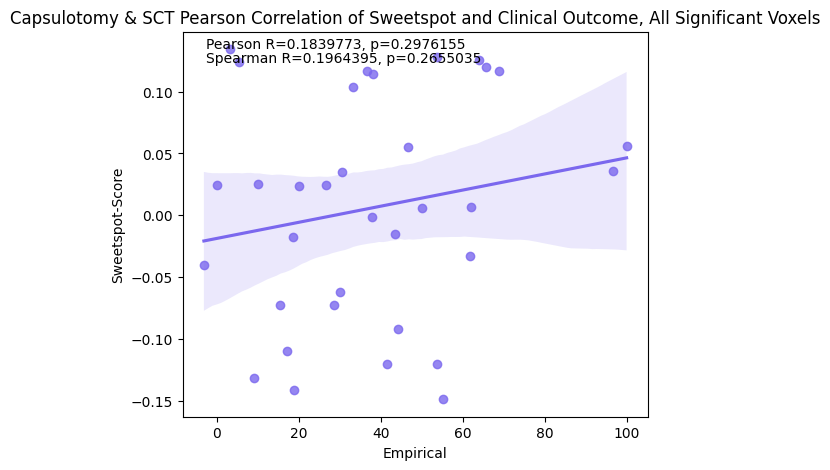

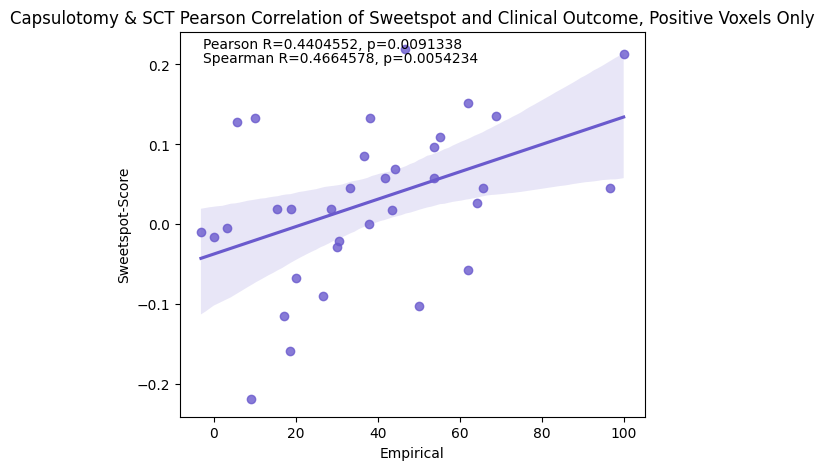

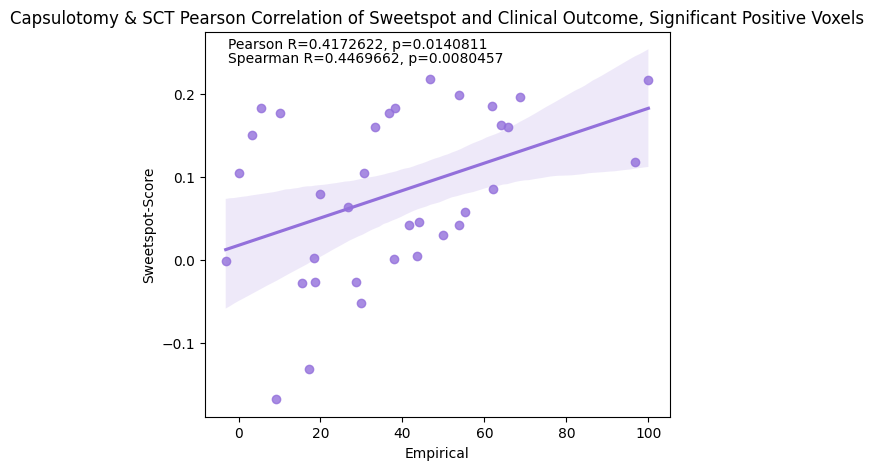

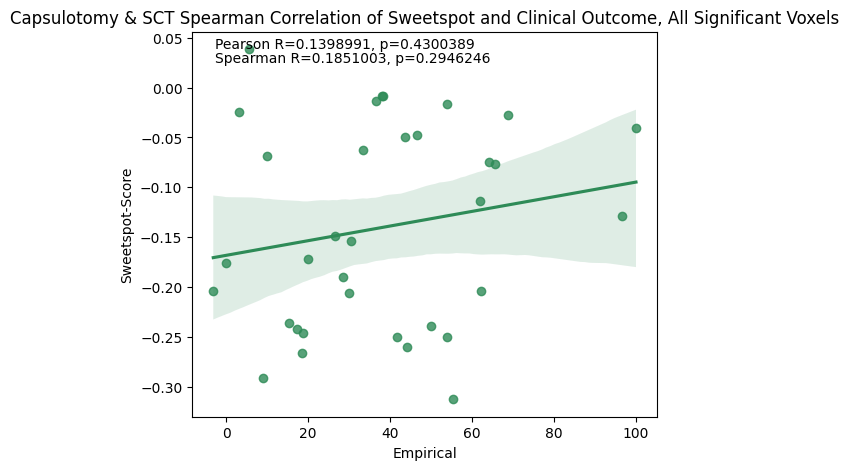

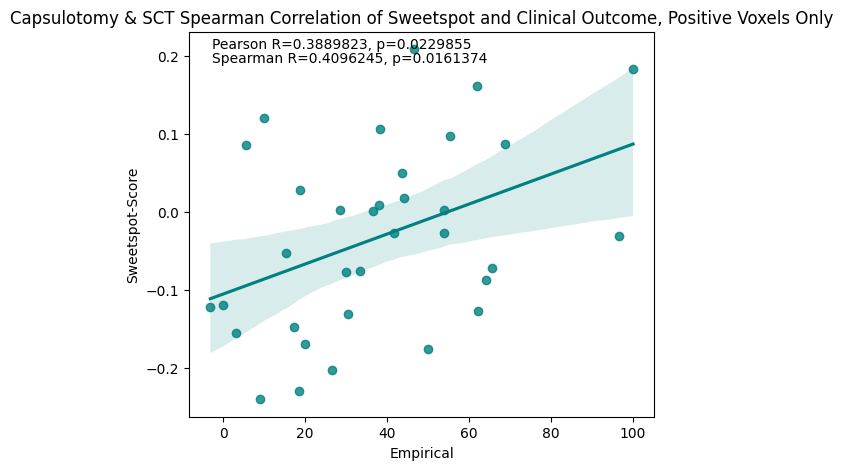

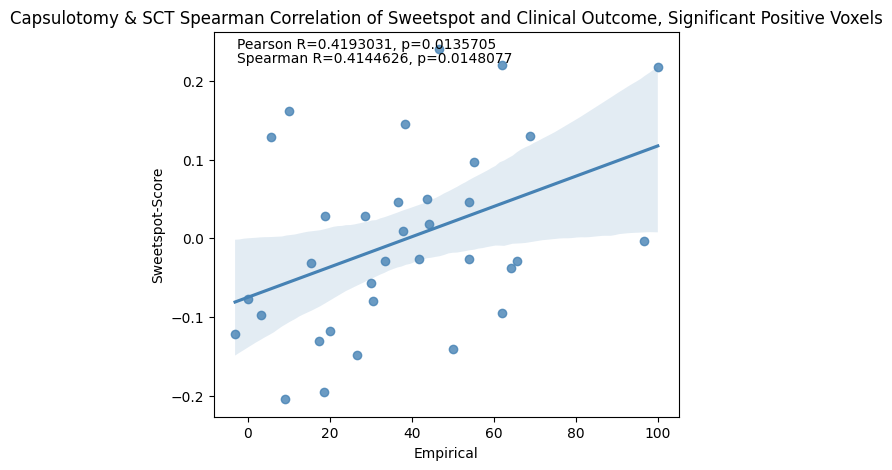

In [52]:
#analysis for capsulotomies and scts, relative, correlations
def plot_analysis(x_data, y_data, title, pearson_r_val, pearson_p_val, spearman_r_val, spearman_p_val, color,save_path=None):
    plt.figure(figsize=(6, 5))
    ax = sns.regplot(x=x_data, y=y_data, color=color)
    plt.title(title)
    plt.xlabel('Empirical')
    plt.ylabel('Sweetspot-Score')
    ax.text(0.05, 0.95, 'Pearson R={:.7f}, p={:.7f}'.format(pearson_r_val, pearson_p_val),
            transform=ax.transAxes, verticalalignment='bottom')
    ax.text(0.05, 0.95, 'Spearman R={:.7f}, p={:.7f}'.format(spearman_r_val, spearman_p_val),
            transform=ax.transAxes, verticalalignment='top')
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

#pearson
plot_analysis(cap_sct_df, all_sig_pearson_sweetspot_corr, 'Capsulotomy & SCT Pearson Correlation of Sweetspot and Clinical Outcome, All Significant Voxels', all_sig_pearson_r, all_sig_pearson_p, s_all_sig_pearson_r, s_all_sig_pearson_p, 'mediumslateblue','/Volumes/Cingulate/Sweetspot_Seg/OCD_Hotspots/Outputs/capsulotomy&sct_all_sig_pearson.png')
plot_analysis(cap_sct_df, pos_pearson_sweetspot_corr, 'Capsulotomy & SCT Pearson Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only',pos_pearson_r, pos_pearson_p, s_pos_pearson_r, s_pos_pearson_p, 'slateblue','/Volumes/Cingulate/Sweetspot_Seg/OCD_Hotspots/Outputs/capsulotomy&sct_pos_pearson.png')
plot_analysis(cap_sct_df, pos_sig_pearson_sweetspot_corr, 'Capsulotomy & SCT Pearson Correlation of Sweetspot and Clinical Outcome, Significant Positive Voxels',pos_sig_pearson_r, pos_sig_pearson_p, s_pos_sig_pearson_r, s_pos_sig_pearson_p, 'mediumpurple','/Volumes/Cingulate/Sweetspot_Seg/OCD_Hotspots/Outputs/capsulotomy&sct_pos_sig_pearson.png')

#spearman
plot_analysis(cap_sct_df, all_sig_spearman_sweetspot_corr, 'Capsulotomy & SCT Spearman Correlation of Sweetspot and Clinical Outcome, All Significant Voxels', all_sig_spearman_r, all_sig_spearman_p, p_all_sig_spearman_r, p_all_sig_spearman_p, 'seagreen','/Volumes/Cingulate/Sweetspot_Seg/OCD_Hotspots/Outputs/capsulotomy&sct_all_sig_spearman.png')
plot_analysis(cap_sct_df, pos_spearman_sweetspot_corr, 'Capsulotomy & SCT Spearman Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only',pos_spearman_r, pos_spearman_p, p_pos_spearman_r, p_pos_spearman_p, 'teal','/Volumes/Cingulate/Sweetspot_Seg/OCD_Hotspots/Outputs/capsulotomy&sct_pos_spearman.png')
plot_analysis(cap_sct_df, pos_sig_spearman_sweetspot_corr, 'Capsulotomy & SCT Spearman Correlation of Sweetspot and Clinical Outcome, Significant Positive Voxels',pos_sig_spearman_r, pos_sig_spearman_p, p_pos_sig_spearman_r, p_pos_sig_spearman_p, 'steelblue','/Volumes/Cingulate/Sweetspot_Seg/OCD_Hotspots/Outputs/capsulotomy&sct_pos_sig_spearman.png')

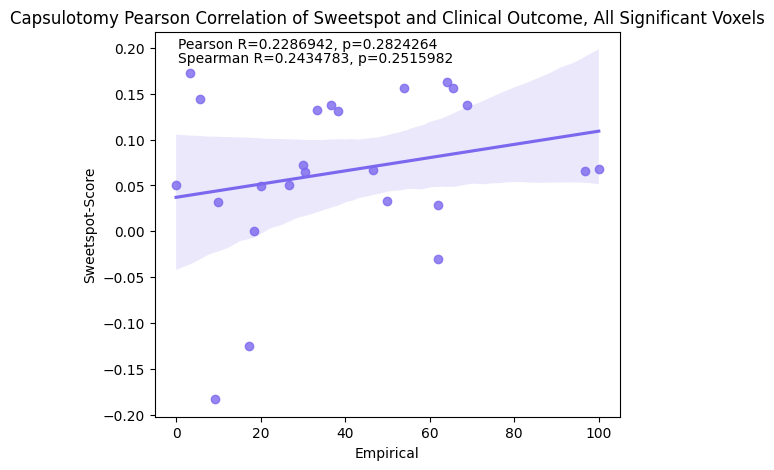

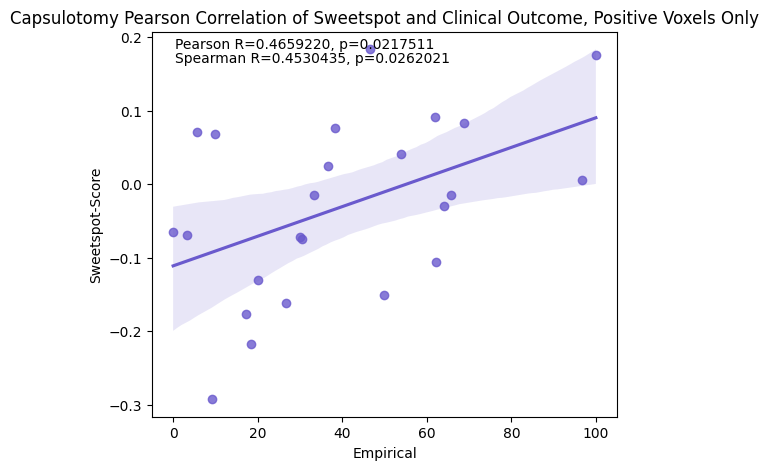

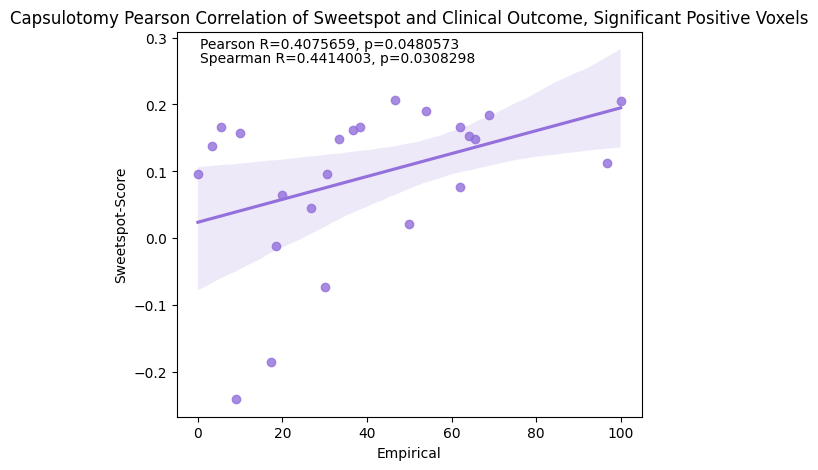

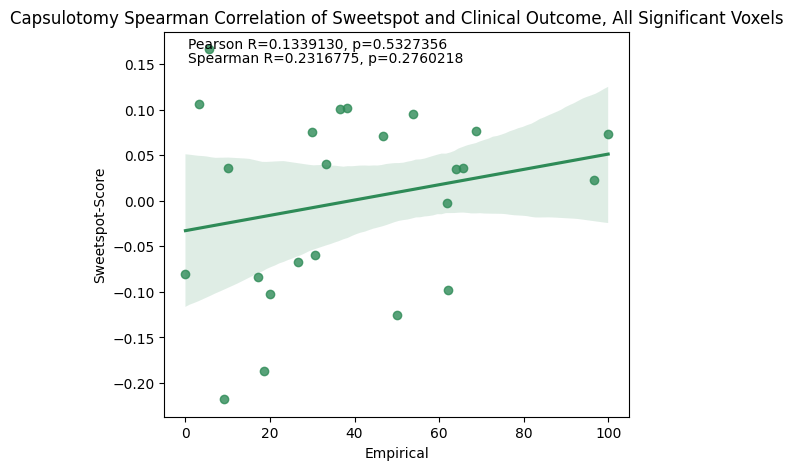

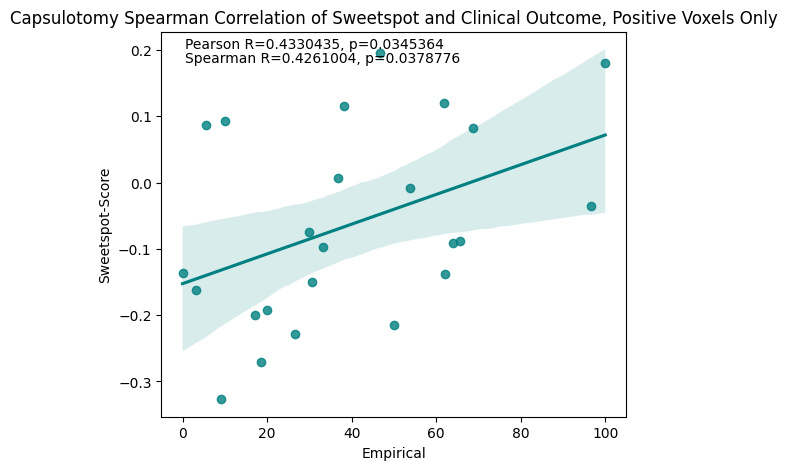

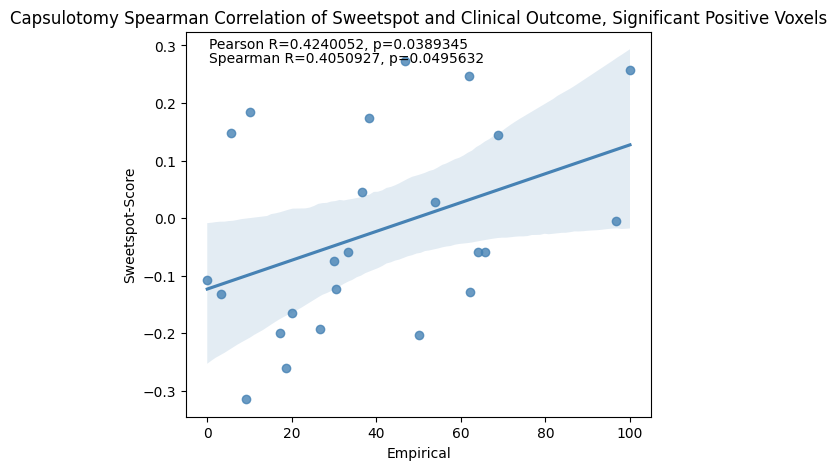

In [54]:
#analysis for capsulotomies, relative, correlations
def plot_analysis(x_data, y_data, title, pearson_r_val, pearson_p_val, spearman_r_val, spearman_p_val, color,save_path=None):
    plt.figure(figsize=(6, 5))
    ax = sns.regplot(x=x_data, y=y_data, color=color)
    plt.title(title)
    plt.xlabel('Empirical')
    plt.ylabel('Sweetspot-Score')
    ax.text(0.05, 0.95, 'Pearson R={:.7f}, p={:.7f}'.format(pearson_r_val, pearson_p_val),
            transform=ax.transAxes, verticalalignment='bottom')
    ax.text(0.05, 0.95, 'Spearman R={:.7f}, p={:.7f}'.format(spearman_r_val, spearman_p_val),
            transform=ax.transAxes, verticalalignment='top')
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

#pearson
plot_analysis(brazil_canada_df, all_sig_pearson_sweetspot_corr, 'Capsulotomy Pearson Correlation of Sweetspot and Clinical Outcome, All Significant Voxels', all_sig_pearson_r, all_sig_pearson_p, s_all_sig_pearson_r, s_all_sig_pearson_p, 'mediumslateblue','/Volumes/Cingulate/Sweetspot_Seg/OCD_Hotspots/Outputs/capsulotomies_all_sig_pearson.png')
plot_analysis(brazil_canada_df, pos_pearson_sweetspot_corr, 'Capsulotomy Pearson Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only',pos_pearson_r, pos_pearson_p, s_pos_pearson_r, s_pos_pearson_p, 'slateblue','/Volumes/Cingulate/Sweetspot_Seg/OCD_Hotspots/Outputs/capsulotomies_pos_pearson.png')
plot_analysis(brazil_canada_df, pos_sig_pearson_sweetspot_corr, 'Capsulotomy Pearson Correlation of Sweetspot and Clinical Outcome, Significant Positive Voxels',pos_sig_pearson_r, pos_sig_pearson_p, s_pos_sig_pearson_r, s_pos_sig_pearson_p, 'mediumpurple','/Volumes/Cingulate/Sweetspot_Seg/OCD_Hotspots/Outputs/capsulotomies_pos_sig_pearson.png')

#spearman
plot_analysis(brazil_canada_df, all_sig_spearman_sweetspot_corr, 'Capsulotomy Spearman Correlation of Sweetspot and Clinical Outcome, All Significant Voxels', all_sig_spearman_r, all_sig_spearman_p, p_all_sig_spearman_r, p_all_sig_spearman_p, 'seagreen','/Volumes/Cingulate/Sweetspot_Seg/OCD_Hotspots/Outputs/capsulotomies_all_sig_spearman.png')
plot_analysis(brazil_canada_df, pos_spearman_sweetspot_corr, 'Capsulotomy Spearman Correlation of Sweetspot and Clinical Outcome, Positive Voxels Only',pos_spearman_r, pos_spearman_p, p_pos_spearman_r, p_pos_spearman_p, 'teal','/Volumes/Cingulate/Sweetspot_Seg/OCD_Hotspots/Outputs/capsulotomies_pos_spearman.png')
plot_analysis(brazil_canada_df, pos_sig_spearman_sweetspot_corr, 'Capsulotomy Spearman Correlation of Sweetspot and Clinical Outcome, Significant Positive Voxels',pos_sig_spearman_r, pos_sig_spearman_p, p_pos_sig_spearman_r, p_pos_sig_spearman_p, 'steelblue','/Volumes/Cingulate/Sweetspot_Seg/OCD_Hotspots/Outputs/capsulotomies_pos_sig_spearman.png')